In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
# import geopandas as gpd # For loading the map of road segments

In [27]:
# Load the data
df = pd.read_csv('Train.csv', parse_dates=['datetime'])
print(df.shape)
df.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


<AxesSubplot:title={'center':'Crash Locations'}, xlabel='longitude', ylabel='latitude'>

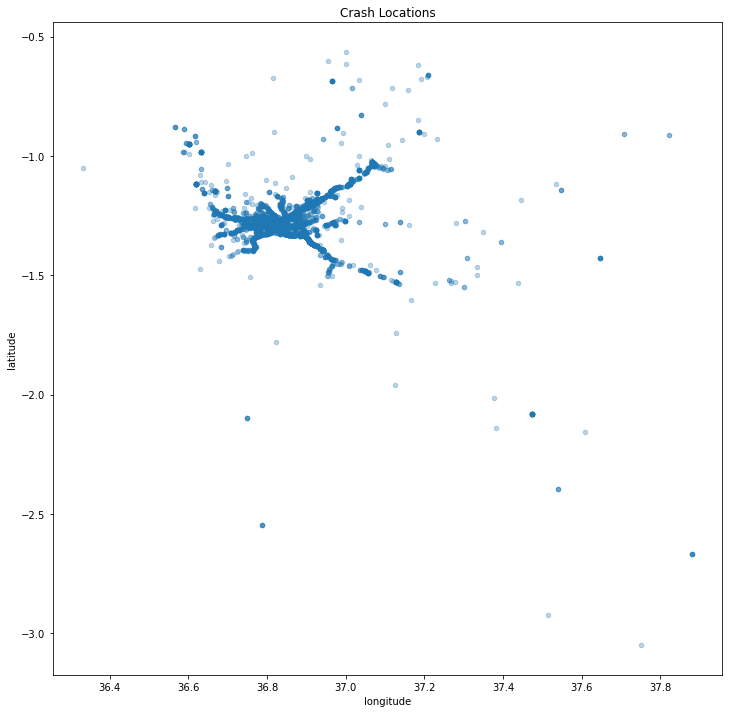

In [28]:
# Plot the crashes
df.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

Rather than trying to predict accident locations or the number of accidents in a given timeframe, we are instead asked to come up with an ambulance deployment schedule that will minimise distance travelled. 

This is of course a simplification of the problem, but by solving this you will hopefully develop strategies that can be used going forward.

# Scoring

You can re-create the scoring process by creating your own test set and using the following function:

In [41]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance


In [30]:
# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
dates

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 03:00:00',
               '2019-01-01 06:00:00', '2019-01-01 09:00:00',
               '2019-01-01 12:00:00', '2019-01-01 15:00:00',
               '2019-01-01 18:00:00', '2019-01-01 21:00:00',
               '2019-01-02 00:00:00', '2019-01-02 03:00:00',
               ...
               '2019-12-30 21:00:00', '2019-12-31 00:00:00',
               '2019-12-31 03:00:00', '2019-12-31 06:00:00',
               '2019-12-31 09:00:00', '2019-12-31 12:00:00',
               '2019-12-31 15:00:00', '2019-12-31 18:00:00',
               '2019-12-31 21:00:00', '2020-01-01 00:00:00'],
              dtype='datetime64[ns]', length=2921, freq='3H')

In [42]:

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = 0
    sub['A'+str(ambulance)+'_Longitude'] = 0

# Place an ambulance in the center of the city:
sub['A'+str(ambulance)+'_Latitude'] = 36.82
sub['A'+str(ambulance)+'_Longitude'] = -1.3



score(sub, reference)

70886.38526378157

In [40]:
# clustering

K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score_kmeans = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]


In [11]:
# Variable with the Longitude and Latitude
X=df.loc[:,['datetime','latitude','longitude']]

kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point


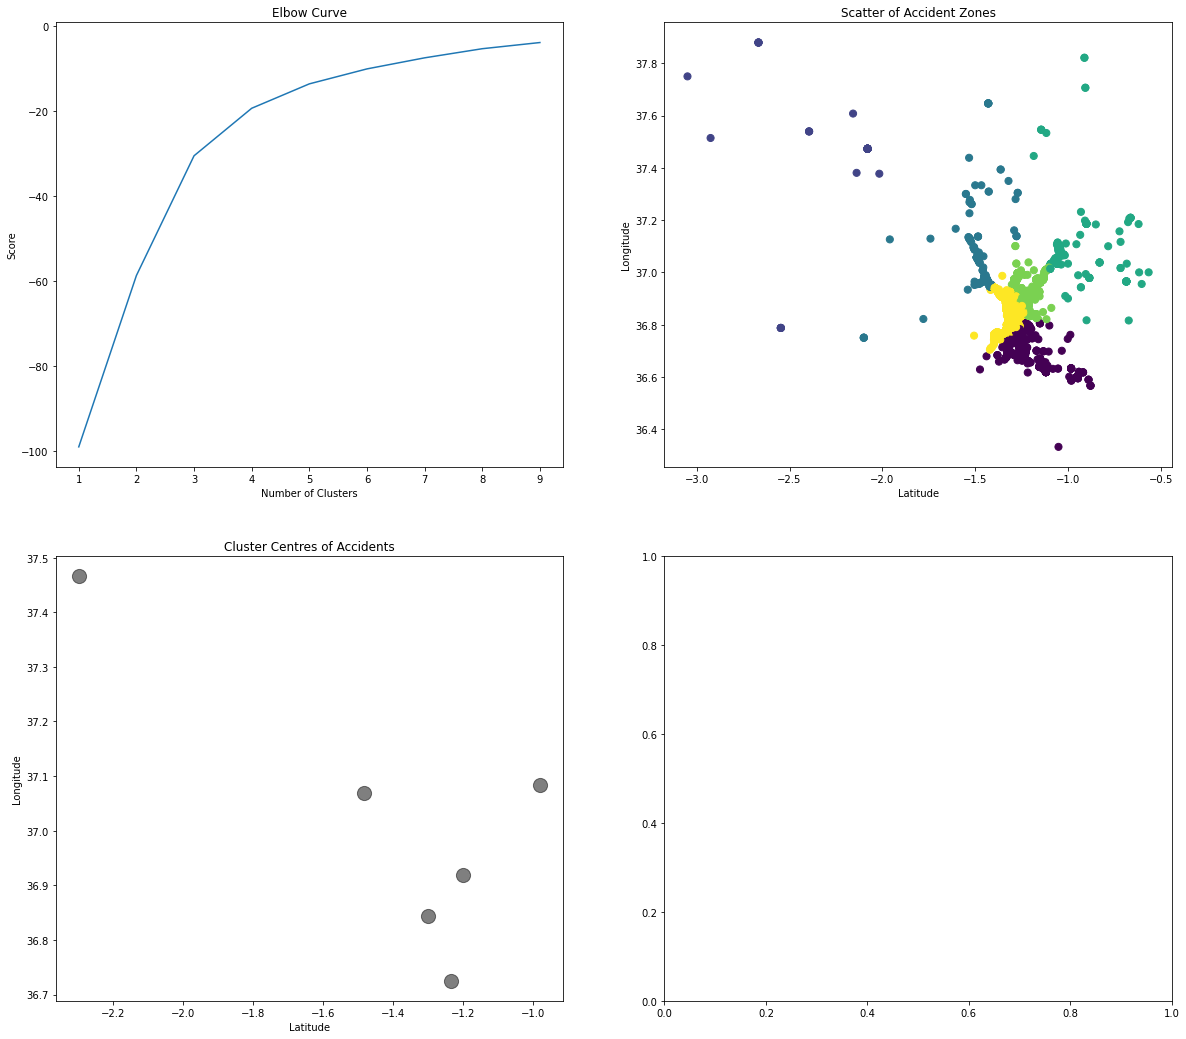

In [55]:
# clustering

K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Variable with the Longitude and Latitude
X=df.loc[:,['datetime','latitude','longitude']]

kmeans = KMeans(n_clusters = 6, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point

# ===== clusters
#X.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')


# ===== road segments locations


fig, axs = plt.subplots(2, 2,figsize=(20, 18))
axs[0, 0].plot(K_clusters, score)
axs[0, 0].set_title('Elbow Curve')
axs[0, 0].set_ylabel('Score')
axs[0, 0].set_xlabel('Number of Clusters')

axs[1,0].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,cmap='viridis')
axs[1, 0].set_title('Cluster Centres of Accidents')
axs[1, 0].set_ylabel('Longitude')
axs[1, 0].set_xlabel('Latitude')

axs[0,1].scatter(x = X['latitude'], y = X['longitude'], c=labels, s=50, cmap='viridis')
axs[0, 1].set_title('Scatter of Accident Zones')
axs[0, 1].set_ylabel('Longitude')
axs[0, 1].set_xlabel('Latitude')

points = pd.DataFrame([centers[:, 0], centers[:, 1]]).transpose()

In [15]:
# result=pd.merge(X,points,
#                how='left')
# plt.scatter(result['latitude'],result['longitude'],c=result['cluster_label'],cmap='Wistia')
# plt.scatter(result[0],result[1])

In [56]:

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = centers.tolist()[ambulance][0]
    sub['A'+str(ambulance)+'_Longitude'] = centers.tolist()[ambulance][1]

# # Place an ambulance in the center of the city:
# sub['A'+str(ambulance)+'_Latitude'] = 36.82
# sub['A'+str(ambulance)+'_Longitude'] = -1.3

In [35]:
sub

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-01-01 00:00:00,-1.211858,36.90679,-1.235349,36.725501,-2.269933,37.385892,-1.304129,36.842402,-1.021416,37.061628,-1.465775,37.074946
1,2019-01-01 03:00:00,-1.211858,36.90679,-1.235349,36.725501,-2.269933,37.385892,-1.304129,36.842402,-1.021416,37.061628,-1.465775,37.074946
2,2019-01-01 06:00:00,-1.211858,36.90679,-1.235349,36.725501,-2.269933,37.385892,-1.304129,36.842402,-1.021416,37.061628,-1.465775,37.074946
3,2019-01-01 09:00:00,-1.211858,36.90679,-1.235349,36.725501,-2.269933,37.385892,-1.304129,36.842402,-1.021416,37.061628,-1.465775,37.074946
4,2019-01-01 12:00:00,-1.211858,36.90679,-1.235349,36.725501,-2.269933,37.385892,-1.304129,36.842402,-1.021416,37.061628,-1.465775,37.074946
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2019-12-31 12:00:00,-1.211858,36.90679,-1.235349,36.725501,-2.269933,37.385892,-1.304129,36.842402,-1.021416,37.061628,-1.465775,37.074946
2917,2019-12-31 15:00:00,-1.211858,36.90679,-1.235349,36.725501,-2.269933,37.385892,-1.304129,36.842402,-1.021416,37.061628,-1.465775,37.074946
2918,2019-12-31 18:00:00,-1.211858,36.90679,-1.235349,36.725501,-2.269933,37.385892,-1.304129,36.842402,-1.021416,37.061628,-1.465775,37.074946
2919,2019-12-31 21:00:00,-1.211858,36.90679,-1.235349,36.725501,-2.269933,37.385892,-1.304129,36.842402,-1.021416,37.061628,-1.465775,37.074946


In [57]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance


In [58]:
#testing new value after clustering
score(sub, reference)

108.79541120939986

In [50]:
sub.to_csv('submission_1.csv',index=False)